In [1]:
import pandas as pd
from pandas import DataFrame,merge,concat,read_csv
import numpy as np
from requests import get
import crisjf_functions as cf
import matplotlib.pyplot as plt
%matplotlib inline


/home/miglesia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Import data

#Import export and RCA
df = DataFrame.from_csv("i_year_origin_hs02_4.tsv", sep="\t")

df = df.replace(np.nan, 0)

#Products
prods = DataFrame.from_csv("products_hs_02.tsv", sep="\t",header=0)

#Print heading
print(df.head())
print(prods.head())

# df.to_csv('RCAdata.csv')
# prods.to_csv('HS02data.csv')

wt, pr, co = cf.trade_data('hs02')

   year origin  hs02  export_val  import_val  export_rca  import_rca
1                                                                   
2  2003    ago   101        0.00     18430.0    0.000000    0.016827
3  2003    ago   102    17821.54   2566670.0    0.004657    1.192530
4  2003    ago   104     6711.52     49352.0    0.007064    0.092357
5  2003    ago   105        0.00    160058.0    0.000000    0.264245
6  2003    ago   106     6458.00     94913.0    0.011895    0.310840
            hs02                                               name
id                                                                 
0101          01                                       Live animals
010101      0101             Live horses, asses, mules and hinnies.
01010110  010110  Live horses/asses/mules/hinnies: pure-bred bre...
01010190  010190  Live horses/asses/mules/hinnies other than pur...
010102      0102                               Live bovine animals.
Retrieving trade data for hs02


In [3]:
# Binarize RCA values
wt['export_rca_bin'] = wt['export_rca'] >= 1
# Select rows with high RCA and group
wt = wt.loc[wt['export_rca_bin'] == True]
wtg = wt.groupby(['ccode', "pcode"])
# keys_select = wtg.groups.keys()[:10]
# keys_select

In [4]:
def complete(key):
    """
    Completes entries in the groups so that they have nice structure. Input is the tuple key: ('ccode', pcode)
    """
    gr = wtg.get_group(key)
    #This is to complete the missing year rows (missing data and low RCA)
    new_index = pd.Index(range(2003,2016), name="year")
    gr.set_index('year')
    gr.set_index("year").reindex(new_index)
    df = gr.set_index("year").reindex(new_index).reset_index()
    #The inserted cols are empty, complete ccode and pcode of this group
    c = gr['ccode'].value_counts().idxmax()
    df['ccode'] = c
    p = gr['pcode'].value_counts().idxmax()
    df['pcode'] = p
    #Binary RCA column is now like (NaN, True, Nan, True), convert this to (0,1,0,1)
    df['export_rca_bin'] = np.logical_not([np.isnan(i) for i in df['export_rca_bin'].values]).astype('int')
    #Difference of this col, lets us detect ups and downs of RCAs
    df['diff'] = df['export_rca_bin'].diff()
    return df

def summarize(df):
    """
    From the output of the function above, make a summary table with one row for each event of RCA going above threshold
    """
    #Events are the years when RCA goes up or down
    events = df.loc[df['diff'] != 0, ('year','ccode','pcode','export_rca_bin')].reset_index()
    #Build the events summary df
    ev_sum = events[events['export_rca_bin'] == 1]
    idxs = np.array(ev_sum.index)
    year_up = np.array(events.ix[idxs]['year'])
    year_down = np.array(events.ix[idxs+1]['year'])
    ev_sum = DataFrame(data={'year_up': year_up, 'year_down': year_down, 'ccode': df['ccode'], 'pcode' : df['pcode'], 'diff' : year_down-year_up}, index = range(len(year_up)))
    #Denote when RCA is up since the beginning, or continues up till the end of sample
    ev_sum['end_of_sample'] = ev_sum['year_down'] == 2015
    ev_sum['start_of_sample'] = ev_sum['year_up'] == 2003
    return ev_sum

# Example
print complete(('che',3909))

print summarize(complete(('che',3909)))

    year ccode  pcode             x  export_rca  export_rca_bin  diff
0   2003   che   3909  1.083874e+08     1.30115               1   NaN
1   2004   che   3909  1.349213e+08     1.40400               1   0.0
2   2005   che   3909  1.423045e+08     1.32700               1   0.0
3   2006   che   3909  1.632327e+08     1.38100               1   0.0
4   2007   che   3909  2.323037e+08     1.48900               1   0.0
5   2008   che   3909  2.392519e+08     1.41000               1   0.0
6   2009   che   3909  1.499433e+08     1.07800               1   0.0
7   2010   che   3909           NaN         NaN               0  -1.0
8   2011   che   3909           NaN         NaN               0   0.0
9   2012   che   3909           NaN         NaN               0   0.0
10  2013   che   3909           NaN         NaN               0   0.0
11  2014   che   3909           NaN         NaN               0   0.0
12  2015   che   3909           NaN         NaN               0   0.0
  ccode  diff  pcode

In [5]:
grouped = wt[['ccode','pcode','year']].groupby(['ccode','pcode'])['year'].apply(list)

In [6]:
c = []
p = []
years_start = []
years_end = []
    
for i,val in zip(grouped.keys(),grouped):
    test_start = [not(y-1 in set(val)) for y in val]
    test_end = [not(y+1 in set(val)) for y in val]
    
    if sum(test_start) == sum(test_end):
        c.append([i[0]] * sum(not(y-1 in set(val)) for y in val))
        p.append([i[1]] * sum(not(y-1 in set(val)) for y in val))

        period = [min(val),0]
        [years_start.append(val[i]) for i in range(len(val)) if test_start[i]]
        [years_end.append(val[i]) for i in range(len(val)) if test_end[i]]
    
    
#Flatten lists
c = [item for sublist in c for item in sublist]
p = [item for sublist in p for item in sublist]

#Year difference    
diff = [x - y +1 for x, y in zip(years_end, years_start)]
    
#     val_ = set(val)
#     for y in val:
#         if not(y+1 in val_):
#             period[-1] = y
#             years.append(period)
#             val_.remove(y)
#             period = [min(val_),0]
#         val_.remove(y)
    
#     print years
    
#min_year = wt.groupby(['ccode','pcode']).min()[['year']].reset_index().rename(columns={'year':'min_year'})
#max_year = wt.groupby(['ccode','pcode']).max()[['year']].reset_index().rename(columns={'year':'max_year'})
# pd.merge(min_year,max_year)


In [7]:
# pd.DataFrame({})
data = DataFrame(data={'years_start': years_start, 'years_end': years_end, 'ccode': c, 'pcode' : p, 'diff' : diff}, index = range(len(years_start)))

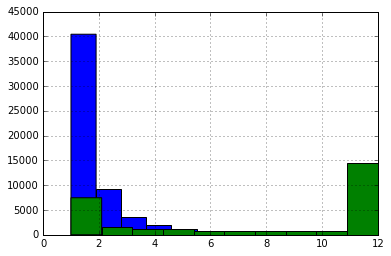

In [8]:
data['start_sam'] = data['years_start'] == 2003
data['end_sam'] = data['years_end'] == 2014

data.loc[(data['end_sam'] == False) & (data['start_sam'] == False)]['diff'].hist()
data.loc[data['end_sam']]['diff'].hist()


# type1 = data.loc[data['start_sam']].groupby(['diff']).count()['ccode']
# type2 = data.loc[data['end_sam']].groupby(['diff']).count()['ccode']
# type3 = data.loc[(data['end_sam'] == False) & (data['start_sam'] == False)].groupby(['diff']).count()['ccode']


In [9]:
#To make calculations faster, do them with small data
# keys_select = wtg.groups.keys()[:10] #There is a strange bug with this, if you take bigger data, you get the error below..
# data = pd.DataFrame([])

#Append all summary tables
# for key in keys_select:
#     data = data.append(pd.DataFrame(summarize(complete(key))), ignore_index=True)

# data

#Next step is to add density col

In [10]:
#RCA matrix

#List of all products
pcodes = wt['pcode'].unique()
#List of all countries
ccodes = wt['ccode'].unique()
#List of years
years = wt['year'].unique()

#Data of 2003 for calculating time-constant proximities
wt2003 = wt.loc[wt['year']==2003]

df = pd.DataFrame(index=ccodes, columns=pcodes)
df = df.fillna(0) 

#Fill 1s where they go (RCA>1)
for index, row in wt2003.iterrows():
    df.set_value(row['ccode'],row['pcode'], row['export_rca_bin'])

#Initialize Proximity matrix
prox2003 = pd.DataFrame(index=pcodes, columns=pcodes)

#Compute correlations between producs (cols of the RCA matrix)
d = np.transpose(df.as_matrix())
prox = [[np.dot(d[i],d[j]) for j in range(len(pcodes))] for i in range(len(pcodes))]
prox = [np.true_divide(row,max(row)) for row in prox]

#Express it as df
proxdf = pd.DataFrame(data=prox,    # values
                    index=pcodes,    # 1st column as index
                    columns=pcodes)  # 1st row as the column names

In [11]:
#Get all pairs of country-years
gr = wt.groupby(['ccode','year'])
c_y_pairs = gr.groups.keys()

#Initialize products of country-year matrix
x = np.zeros((len(c_y_pairs),len(pcodes)))

#Compute 
for i in range(len(c_y_pairs)):
    p = wt.loc[(wt['ccode'] == c_y_pairs[i][0]) & (wt['year'] == c_y_pairs[i][1])]['pcode'].values #values of pcodes
    x[i] = [int(pc in p) for pc in pcodes] #Get bool by comparing with pcodes (list of products)
    
#Compute 
# x = []
# for i,val in zip(wt.keys(),wt):
#     p = wt.loc[(wt['ccode'] == i[0]) & (wt['year'] == i[1])]['pcode'].values #values of pcodes
#     x.append([int(pc in p) for pc in pcodes]) #Get bool by comparing with pcodes (list of products)
    
#Express it as df
xdf = pd.DataFrame(data=x,    # values
                    index=pd.MultiIndex.from_tuples(c_y_pairs, names=('ccode', 'year')),
                    columns=pcodes)  # 1st row as the column names



In [66]:
#Calculate density
w = []
d = []
for index, row in data.iterrows():
    c = row['ccode']
    p = row['pcode']
    y = row['years_start']
    
    x_c_y = np.array(xdf.loc[(xdf.index.get_level_values('ccode') == c) & (xdf.index.get_level_values('year') == y)])[0]
    phi_p = np.array(proxdf[p])
    s = sum(phi_p)
    
    w.append(np.dot(x_c_y,phi_p)/s)
    
    d.append(sum(x_c_y))
    
    
data['Density'] = w
data['Diversity'] = d

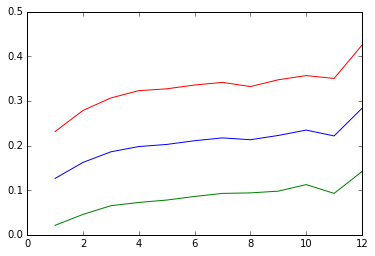

In [13]:
mean = data.groupby(['diff']).mean()['Density']
std = data.groupby(['diff']).std()['Density']

# print mean
# print std 
# mean+std

plt.plot(mean)
plt.plot(mean-std)
plt.plot(mean+std)
plt.ylim((0,0.5))
plt.show()

In [67]:
#Anecdotes and more 
df = data.loc[(data['end_sam'] == True) & (data['diff'] < 12) & (data['diff'] > 2)].sort('Density',ascending=True)

print df.groupby(['ccode'])['ccode','years_start','Density','Diversity'].mean().sort('Density',ascending=False)

       years_start   Density   Diversity
ccode                                   
deu    2008.641304  0.537146  560.021739
ita    2008.574074  0.481029  567.833333
fra    2008.641509  0.449347  514.216981
usa    2008.688889  0.443719  500.366667
esp    2008.306122  0.423563  510.340136
chn    2007.867925  0.411434  527.044025
aut    2008.682927  0.387504  433.060976
cze    2008.828571  0.366439  403.209524
gbr    2009.209877  0.363458  403.456790
nld    2008.694915  0.359593  420.830508
pol    2008.288136  0.351516  417.245763
jpn    2009.150000  0.335949  337.762500
prt    2008.572519  0.328297  407.152672
ind    2009.666667  0.318069  394.268817
tur    2007.921569  0.301478  384.000000
swe    2008.404494  0.300015  325.741573
svn    2008.459770  0.289537  319.724138
dnk    2008.961039  0.286323  335.051948
che    2008.250000  0.280905  300.150000
hkg    2008.488372  0.269689  342.558140
srb    2006.326360  0.258458  304.167364
bgr    2008.964286  0.254029  321.419643
grc    2007.7400

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


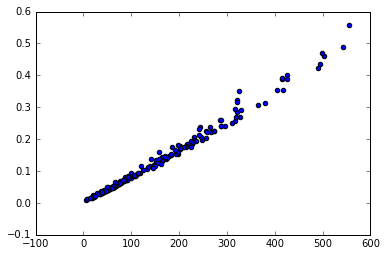

In [74]:
df = data.groupby(['ccode'])['ccode','years_start','Density','Diversity'].mean()
plt.scatter(df['Diversity'], df['Density'])
# plt.xscale('log')

In [23]:
#Merge GDP

gdp = DataFrame.from_csv("GDPpercapcurrentUSS.csv", sep=",")
# df = df.replace(np.nan, 0)
gdp['mean_gdp_pc'] = gdp.ix[:, gdp.columns != 'ccode'].mean(axis = 1)
gdp['avg_growth'] = np.true_divide(gdp['2014'],gdp['2003'])-1
gdp = gdp.sort('avg_growth',ascending = True)

#Merge product names

prods = DataFrame.from_csv("products_hs_02.tsv", sep="\t",header=0)

prods['pcode'] = prods['hs02']
del prods['hs02']
prods


# data.merge(prods, how='left').sort('Density',ascending=False)

data = data.merge(gdp[['ccode','mean_gdp_pc','avg_growth']])



/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [83]:
# data.to_csv('ComplexityStats.csv
data

,ccode,diff,pcode,years_end,years_start,start_sam,end_sam,Density,mean_gdp_pc,avg_growth,Diversity
0,afg,1,102,2010,2010,False,False,0.095842,446.661152,2.112916,120.0
1,afg,1,104,2010,2010,False,False,0.119191,446.661152,2.112916,120.0
2,afg,1,105,2003,2003,True,False,0.061805,446.661152,2.112916,78.0
3,afg,1,106,2003,2003,True,False,0.072857,446.661152,2.112916,78.0
4,afg,1,106,2007,2007,False,False,0.083211,446.661152,2.112916,90.0
5,afg,2,106,2012,2011,False,False,0.071555,446.661152,2.112916,76.0
6,afg,1,106,2014,2014,False,True,0.062638,446.661152,2.112916,67.0
7,afg,1,208,2006,2006,False,False,0.059751,446.661152,2.112916,86.0
8,afg,1,303,2009,2009,False,False,0.121965,446.661152,2.112916,156.0
9,afg,1,305,2008,2008,False,False,0.085046,446.661152,2.112916,100.0


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


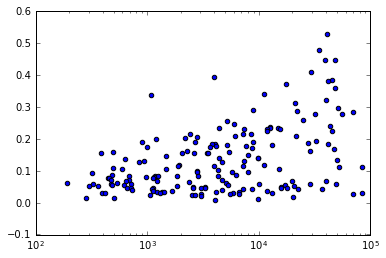

,years_start,Density,mean_gdp_pc,avg_growth,Diversity
ccode,,,,,
chn,2006.030,0.393845,3995.705929,4.962476,511.56000
ind,2006.375,0.337221,1093.298289,1.814033,419.96875


In [78]:
data

df = data.loc[(data['end_sam'] == True) & (data['diff'] < 12) & (data['diff'] > 5)].sort('Density',ascending=True)

summary = df.groupby(['ccode'])['ccode','years_start','Density','mean_gdp_pc','avg_growth','Diversity'].mean().sort('Density',ascending=False)

# summary.scatter(x='mean_gdp_pc', y='Density', style='o')

plt.scatter(summary['mean_gdp_pc'], summary['Density'])
plt.xscale('log')

summary = summary.loc[summary['avg_growth'] > 0.1]

# plt.scatter(summary['avg_growth'], summary['Density'])
# plt.xscale('log')
plt.show()

# ccodes

# Regions: arab, latin, africa, europe, NorthAm, Ocean, Asia

summary.loc[(summary['mean_gdp_pc'] < 7000) & (summary['Density'] > 0.3)]

In [44]:
summary.sort('avg_growth',ascending=False)

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,years_start,Density,mean_gdp_pc,avg_growth
ccode,,,,
aze,2007.714286,0.036818,4706.731620,7.925231
mng,2008.375000,0.055831,2389.079673,5.503038
tkm,2010.500000,0.030117,4154.633551,5.375520
kaz,2009.066667,0.084169,8020.434014,5.192359
gnq,2006.000000,0.018390,20275.611194,5.174120
nga,2010.444444,0.036341,1676.150753,5.036333
chn,2007.867925,0.411434,3995.705929,4.962476
mmr,2009.551724,0.085276,691.827003,4.762450
mac,2008.928571,0.147445,50105.567781,4.284459


In [16]:


# wt1 = wt.loc[wt['export_rca'] >1]
# x = wt1.loc[wt['year'] == 2014]
# x['pcode'] = x['pcode'].apply(str)

# co_contcode = {v: k for k, v in dict(enumerate(np.unique(x['ccode']))).iteritems()}
# pr_contcode = {v: k for k, v in dict(enumerate(np.unique(x['pcode']))).iteritems()}

# x = x.replace({"ccode": co_contcode})
# x = x.replace({"pcode": pr_contcode})
# # x
# x = np.asarray(x, dtype=float)
# x = np.array(x[:,(1,2)], dtype = int)

In [17]:
# ind = [(row[0], row[1]) for row in x]

# RCA = np.zeros((max(x[:,0])+1,max(x[:,1])+1),dtype=bool)

# for i in ind:
#     RCA[i] = True


In [18]:
# plt.figure(figsize=(10,2))
# plt.imshow(RCA,cmap=plt.cm.Greys)
# plt.show()

In [19]:
# plt.figure(figsize=(25,2))
# order = np.argsort([sum(country) for country in RCA])
# RCAco = RCA[order]
# plt.imshow(RCAco,cmap=plt.cm.Greys)
# order2 = np.argsort([sum(prod) for prod in np.transpose(RCAco)])
# RCAcopo = np.transpose(np.transpose(RCAco)[order2])
# plt.imshow(RCAcopo,cmap=plt.cm.Greys)
# plt.show()

In [20]:
# wt1 = wt.loc[wt['export_rca'] >1]
# x = wt1.loc[wt['year'] == 2014]
# x['pcode'] = x['pcode'].apply(str)

# co_contcode = {v: k for k, v in dict(enumerate(np.unique(x['ccode']))).iteritems()}
# pr_contcode = {v: k for k, v in dict(enumerate(np.unique(x['pcode']))).iteritems()}

# x = x.replace({"ccode": co_contcode})
# x = x.replace({"pcode": pr_contcode})
# # x
# x = np.asarray(x, dtype=float)
# x = np.array(x[:,(1,2)], dtype = int)

In [21]:
# arg = wt.loc[(wt['ccode'] == 'arg')]

# n = len(arg)


# arg['rca_perc'] = arg['export_rca']
# # grouped = arg.groupby('year')
# # grouped.agg({'year': arg['rca_perc'].rank(method = 'max')})
# arg['rca_perc'] = arg['rca_perc'].rank(method = 'max')/n
# arg
